<a href="https://colab.research.google.com/github/varmatilak22/learning_tensorflow/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part-2:Fint-tunning

In the previous notebook,we covered transfer learning feature extraction,now its time to learn about a new kind of transfer learning:fine-tunning.

In [ ]:
#Check if we're using a GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Creating Helper functions
In previous notebook, we've created a bunch of helper functions, now we could rewrite them all,however it is tedious.

So,its a good idea to put functions you'll want to see again in a script you can download and import into your notebooks(or elsewhere).

We've done this for some of the functions we've used previously here:
[Helper.py](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py)

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-21 07:42:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-07-21 07:42:30 (10.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

> 🔑**Notes:** If you;re encountered this notebook in google colab,when its times out colab will delete `helper_functions.py` so you'll have to downloaded it you want access to your helper function.

## Lets gets some data
This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem(recognizing images of food).

[Tensorflow_Keras_Applications](https://colab.research.google.com/drive/1tYeCIEzSYXgDUht42cRKrLSxKo-3HeWb#scrollTo=aF7E9uoSQEx9)

In [ ]:
#Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-07-21 07:42:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.207, 142.250.157.207, 142.251.8.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  26.7MB/s    in 7.5s    

2024-07-21 07:42:44 (21.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
unzip_data('10_food_classes_10_percent.zip')

In [ ]:
#Check out how many images and directories in the dataset?
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
#Create training and test directory paths
train_dir='10_food_classes_10_percent/train/'
test_dir='10_food_classes_10_percent/test/'

In [ ]:
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE=32
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_data_10_percent=image_dataset_from_directory(directory=train_dir,
                                                  image_size=IMG_SIZE,
                                                  label_mode='categorical',
                                                  batch_size=BATCH_SIZE) #Good for our health

test_data=image_dataset_from_directory(directory=test_dir,
                                      image_size=IMG_SIZE,
                                      label_mode='categorical',
                                      batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:


#Check out the class names of our dataset
class_names=train_data_10_percent.class_names

In [ ]:
#See the example of a batch of data
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[9.39438782e+01 6.99438782e+01 4.19438782e+01]
   [1.02260201e+02 7.92602005e+01 4.79285698e+01]
   [1.15076530e+02 9.21530609e+01 5.79234695e+01]
   ...
   [1.26076721e+02 1.08648193e+02 9.30001984e+01]
   [1.37882690e+02 1.22882698e+02 1.01882698e+02]
   [1.38515259e+02 1.26515259e+02 1.02515259e+02]]

  [[8.67602081e+01 6.07602043e+01 3.37602043e+01]
   [8.92091827e+01 6.61428604e+01 3.53418350e+01]
   [9.60000000e+01 7.30000000e+01 4.08571396e+01]
   ...
   [1.32341995e+02 1.13984894e+02 1.00469521e+02]
   [1.41076553e+02 1.26076561e+02 1.06801025e+02]
   [1.41285645e+02 1.26285645e+02 1.03285645e+02]]

  [[8.81377563e+01 6.21377563e+01 3.71377563e+01]
   [8.86836700e+01 6.26836739e+01 3.56836739e+01]
   [9.44030609e+01 7.11887741e+01 4.08316345e+01]
   ...
   [1.29811386e+02 1.11428764e+02 1.00500130e+02]
   [1.40928604e+02 1.23500023e+02 1.07571426e+02]
   [1.41285645e+02 1.24351997e+02 1.03510078e+02]]

  ...

  [[1.45433670e+02 1.21433662e+02 8.58621902e+01]
   [1

In [ ]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

### Tensorflow Applications:
* `tf.keras.applications` is a module in Tensorflow keras that provides a pretrained model and associated functions for deep learning applications.
* This models are trained on large benchmark dataset like ImageNet.

In [ ]:
#Import the pkgs
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [ ]:
#Create a model
efficientnet_model=Sequential([
    EfficientNetB0(include_top=False,
                   weights='imagenet',
                   input_shape=IMG_SIZE+(3,)),
    GlobalAveragePooling2D(),
    Dense(10,activation='softmax')
])

#efficientnet_model.trainable=False #Freeze the efficientnet model
#Compile the model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=Adam(),
                           metrics=['accuracy'])

#Fit the model
efficientnet_history=efficientnet_model.fit(train_data_10_percent,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data,
                                            validation_steps=len(test_data),
                                            callbacks=[create_tensorboard_callback(
                                                dir_name='tensorflow_hub',
                                                experiment_name='EfficientNetV2B0')])

16705208/16705208 [==============================] - 2s 0us/step
Saving TensorBoard log files to: tensorflow_hub/EfficientNetV2B0/20240721-074303
Epoch 1/5
24/24 [==============================] - 513s 19s/step - loss: 1.3676 - accuracy: 0.5573 - val_loss: 1.6798 - val_accuracy: 0.5900
Epoch 2/5
24/24 [==============================] - 413s 18s/step - loss: 0.2884 - accuracy: 0.9160 - val_loss: 1.0657 - val_accuracy: 0.6764
Epoch 3/5
24/24 [==============================] - 372s 16s/step - loss: 0.0843 - accuracy: 0.9760 - val_loss: 0.8453 - val_accuracy: 0.7624
Epoch 4/5
24/24 [==============================] - 398s 17s/step - loss: 0.0536 - accuracy: 0.9840 - val_loss: 0.9759 - val_accuracy: 0.7484
Epoch 5/5
24/24 [==============================] - 357s 15s/step - loss: 0.0747 - accuracy: 0.9813 - val_loss: 0.8127 - val_accuracy: 0.7904


In [ ]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 4020358 (15.34 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


## Model 0 : Building a transfer learning(Feature Extraction) model using the keras functional API

The sequential API is straight-forward,it runs our layers in sequential order.
But the functional API gives us more flexibility with our models.

In [ ]:
# 1.Create base model with tf.keras.applications
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2.Freeze the base model(so the underlying pre-trained patterns aren;t updated during training)
base_model.trainable=False

# 3.Create inputs into our model
inputs=tf.keras.layers.Input(shape=(224,224,3),name='Input Layer')

# 4. Optional if using ResNet50V2 you will need to normalise inputs
#x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x=base_model(inputs)
print(f"Shape after parsing inputs through the base model:{x.shape}")

# 6.Average Pool the outputs of the base model (aggregate all the most important information,reduce number of computations.)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"Shape after GlobalAveragePooling2D:{x.shape}")

# 7.Create output activation layers
outputs=tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

# 8.Combine the inputs with the outputs
model_0=tf.keras.Model(inputs,outputs)

# 9.Compile for the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# 10.Fit the model and save its history
history_10_percent=model_0.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25*len(test_data)),
            callbacks=[create_tensorboard_callback(
                dir_name='transfer_learning',
                experiment_name='10_percent_feature_extraction'
            )])

24274472/24274472 [==============================] - 2s 0us/step
Shape after parsing inputs through the base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240721-081758
Epoch 1/5
24/24 [==============================] - 88s 3s/step - loss: 1.9391 - accuracy: 0.4000 - val_loss: 1.3344 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - 63s 3s/step - loss: 1.1893 - accuracy: 0.7333 - val_loss: 0.8764 - val_accuracy: 0.8355
Epoch 3/5
24/24 [==============================] - 63s 3s/step - loss: 0.8604 - accuracy: 0.8200 - val_loss: 0.6886 - val_accuracy: 0.8553
Epoch 4/5
24/24 [==============================] - 76s 3s/step - loss: 0.7114 - accuracy: 0.8507 - val_loss: 0.5902 - val_accuracy: 0.8701
Epoch 5/5
24/24 [==============================] - 76s 3s/step - loss: 0.6034 - accuracy: 0.8680 - val_loss: 0.5269 - val_accuracy: 0.8865


In [ ]:
#Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 115s 1s/step - loss: 0.5759 - accuracy: 0.8536


[0.5759175419807434, 0.853600025177002]

In [ ]:
#check the layers in our base model
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name )

0 input_2
1 rescaling_2
2 normalization_1
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [ ]:
#How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, None, None, 3)        0         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [ ]:
#How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

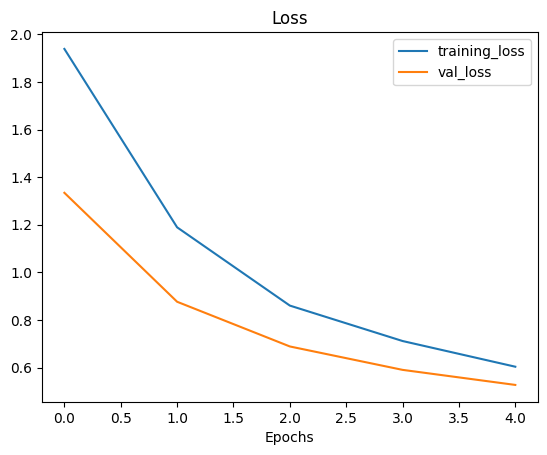

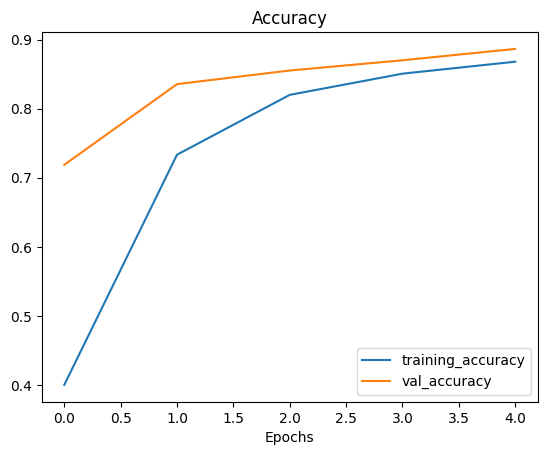

In [ ]:
#Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a Feature Vector from a trained model.

Let's demonstrate the GLobal Average Pooling Layers ...
We have a tensor after our model goes through `base_model` of shape(None,7,7,1280)...

But then when it passes through `GlobalAveragePooling2D`,it turns into (None,1280)

Lets use similar shape tensor of (1,4,4,3) and then pass it to `GlobalAveragePooling2D`

In [ ]:
#Set the random seed
tf.random.set_seed(1)

#Define the input shape
input_shape=(1,4,4,3)

# Create a random Tensor
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

#pass the random tensor through a global average pooling 2d layer
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D Global Average Pooled Random Tensor:\n{global_average_pooled_tensor}\n")

#Check the shape of different tensors
print(f"Shape of Input Tensor:{input_tensor.shape}")
print(f"Shape of Global Average Pooled Tensor:{global_average_pooled_tensor.shape}")

Random input tensor:
[[[[-1.1012203   1.5457517   0.383644  ]
   [-0.87965786 -1.2246722  -0.9811211 ]
   [ 0.08780783 -0.20326038 -0.5581562 ]
   [-0.72054404 -0.6259924  -0.71502596]]

  [[-0.34835446 -0.33646983  0.18257578]
   [ 1.1085953   1.2796587  -0.02147584]
   [-0.31968883  0.37332553  0.25279108]
   [ 0.6437664   2.146308   -0.82514983]]

  [[-0.9041368   1.3948786   1.2248751 ]
   [ 0.0586496  -0.49213138 -0.81997806]
   [-0.18526012 -0.39277685 -0.6585226 ]
   [-0.9833388   0.38883775 -1.0372448 ]]

  [[-1.5600569  -0.15791255 -0.3566943 ]
   [-0.20044029  1.613107    0.6796728 ]
   [ 0.08133233  1.3380764   1.1848053 ]
   [-0.35381562 -0.10400175 -0.75114644]]]]

2D Global Average Pooled Random Tensor:
[[-0.3485227   0.40892038 -0.17600942]]

Shape of Input Tensor:(1, 4, 4, 3)
Shape of Global Average Pooled Tensor:(1, 3)


In [ ]:
#Lets replicate the GlobalAveragePooling2D layer
print(tf.reduce_mean(input_tensor,axis=[0,3]))
print(tf.reduce_mean(input_tensor,axis=[1,3]))
print(tf.reduce_mean(input_tensor,axis=[0,2]))
print(tf.reduce_mean(input_tensor,axis=[1,2]))

tf.Tensor(
[[ 0.27605847 -1.0284837  -0.22453624 -0.68718743]
 [-0.16741617  0.78892606  0.10214259  0.6549749 ]
 [ 0.5718723  -0.41781995 -0.41218653 -0.5439153 ]
 [-0.69155455  0.6974465   0.8680713  -0.40298796]], shape=(4, 4), dtype=float32)
tf.Tensor([[-0.00276     0.01001721  0.08337278 -0.24477899]], shape=(1, 4), dtype=float32)
tf.Tensor(
[[-0.6534036  -0.12704332 -0.46766478]
 [ 0.2710796   0.8657056  -0.1028147 ]
 [-0.5035215   0.22470205 -0.3227176 ]
 [-0.5082451   0.67231727  0.18915933]], shape=(4, 3), dtype=float32)
tf.Tensor([[-0.3485227   0.40892038 -0.17600942]], shape=(1, 3), dtype=float32)


>  ⚒ **Practice:** Try do the same with the above two cells but this time use `GlobalMaxPool2D` and see what happens...


In [ ]:
global_max_pooling_layer=tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"After GlobalMaxPool2D Shape:\n{global_max_pooling_layer.shape}")

After GlobalMaxPool2D Shape:
(1, 3)


Its also does the same operation like `GlobalAveragePooling2D` converting `4D Tensor` into `2D Tensor`

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data,but how does it go with 1% of training data.

Experiments to find out:
1. `model_1`-use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training and data augmentation
3. `model_3`- fine tunning transfer learning on 10% of training data wth data augmentation.
4. `model_4`- use fine tunning transfer learning on 100% of the training data.

> **Note:** Throughout all experiments the same test dataset will used to evaluate our model... this ensure consistency across evaluation metrics.

In [ ]:
#Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2024-07-21 08:26:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.207, 74.125.203.207, 74.125.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  11.7MB/s    in 14s     

2024-07-21 08:26:58 (9.31 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
unzip_data('10_food_classes_1_percent.zip')

In [ ]:
#dir path
train_dir_1_percent='10_food_classes_1_percent/train/'
test_dir='10_food_classes_1_percent/test/'

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_data_1_percent=image_dataset_from_directory(directory=train_dir_1_percent,
                                                  image_size=(224,224),
                                                  batch_size=32,
                                                  label_mode='categorical')

test_data=image_dataset_from_directory(directory=test_dir,
                                                  image_size=(224,224),
                                                  batch_size=32,
                                                  label_mode='categorical')

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
#How many images are we working with?
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

In [ ]:
len(train_data_1_percent)

3

## Adding Data augmentation right into the model

To add data augmentation right into our models,we can use the layers inside:

* `tf.keras.experimental.preprocessing`


We can see the advantage of using this within the tensorflow Data Augmentation:[link](https://www.tensorflow.org/tutorials/images/data_augmentation)

Off the top our of heads,after reading the docs the benfits of using data augmentation  inside the model.
* Preprocessing of images(augmenting them) happens on the CPU (much faster) rather than the CPU.
* ImageData Augmentation happens during training, so we can still export our whole model and use it elsewhere.



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation stage with horizontal,flipping,rotations,zooms,etc.
data_augmentation=keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.Rescaling(1./255) # keep for models like ResNet50 but efficientNet having rescaing built in
],name='data_augmentation')

### visualise our data augmentation layer (and see what happens to our data)


Target Class:fried_rice
target_dir:10_food_classes_1_percent/train/fried_rice
Random Image:492857.jpg
img_path:10_food_classes_1_percent/train/fried_rice/492857.jpg
img_shape(384, 512, 3)


(-0.5, 591.5, 451.5, -0.5)

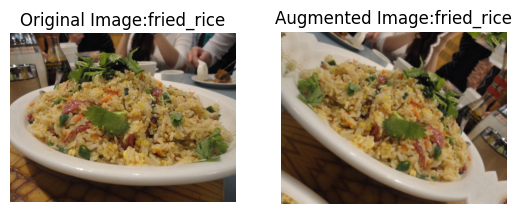

In [ ]:
#View a random image and compare it to its augmentation version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class=random.choice(train_data_1_percent.class_names)
print(f"Target Class:{target_class}")

target_dir='10_food_classes_1_percent/train/'+target_class
print(f"target_dir:{target_dir}")

rand_img=random.choice(os.listdir(target_dir))
print(f"Random Image:{rand_img}")

img_path=target_dir+'/'+rand_img
print(f"img_path:{img_path}")

img=mpimg.imread(img_path)
print(f"img_shape{img.shape}")

#Now augment the image
augmented_img=data_augmentation(img,training=True)


#plot the image

plt.subplot(1,2,1)
plt.title(f"Original Image:{target_class}")
plt.imshow(img)
plt.axis('off')
plt.subplot(1,2,2)
plt.title(f"Augmented Image:{target_class}")
plt.imshow(augmented_img)
plt.axis('off')

> 🔑**Note** What does data augmentation do? Ans. It artificially increase the diversity in the training data.

## Model 1:Feature Extraction transfer learning 1% of dataset


In [ ]:
#Setup input shape and base model,freeze the basemodel layers
input_layer=tf.keras.layers.Input(shape=(224,224,3),name='Input_layer')
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

#Add in data augmentation sequential model as a layer
x=data_augmentation(input_layer)

#Give base_model inputs (after augmentation) and don't train it
x=base_model(x,training=False)

#Pool output features of Base model
x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

#Put a dense layer on as the output
output_layer=tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

#Make a model using Inputs and Outputs
model_1=tf.keras.Model(input_layer,output_layer)

#Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

#Fit the model
history_1_percent=model_1.fit(train_data_1_percent,
            epochs=5,
            steps_per_epoch=len(train_data_1_percent),
            validation_data=test_data,
            validation_steps=len(test_data),
            callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                   experiment_name='1_percent_feature_extraction')])

Saving TensorBoard log files to: tensorflow_hub/1_percent_feature_extraction/20240721-082705
Epoch 1/5
3/3 [==============================] - 127s 58s/step - loss: 2.3616 - accuracy: 0.0714 - val_loss: 2.3135 - val_accuracy: 0.1000
Epoch 2/5
3/3 [==============================] - 145s 72s/step - loss: 2.3270 - accuracy: 0.0857 - val_loss: 2.3371 - val_accuracy: 0.1000
Epoch 3/5
3/3 [==============================] - 115s 56s/step - loss: 2.3254 - accuracy: 0.1000 - val_loss: 2.3399 - val_accuracy: 0.1000
Epoch 4/5
3/3 [==============================] - 118s 58s/step - loss: 2.3455 - accuracy: 0.0714 - val_loss: 2.3342 - val_accuracy: 0.1012
Epoch 5/5
3/3 [==============================] - 117s 57s/step - loss: 2.3206 - accuracy: 0.0714 - val_loss: 2.3251 - val_accuracy: 0.1000


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 3)           0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [ ]:
#Evaluate on the full dataset
results_1_percent=model_1.evaluate(test_data)

79/79 [==============================] - 111s 1s/step - loss: 2.3251 - accuracy: 0.1000


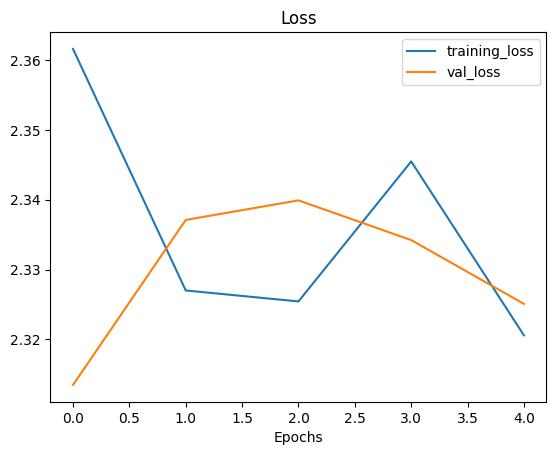

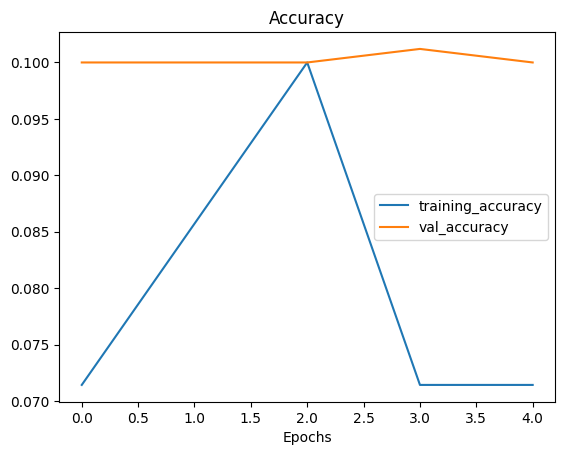

In [ ]:
# how to the 1% of the data and Plot the loss curves
plot_loss_curves(history_1_percent)

## Model_2:Feature extraction transfer learning model with 10% of data and data augmentation

### 1. BEcome one with the data

In [ ]:
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [ ]:
#unzip_data('10_food_classes_10_percent.zip')

In [ ]:
"""
## get the train and test dir
train_dir_10_percent='10_food_classes_10_percent/train/'
test_dir_10_percent='10_food_classes_10_percent/test/'

IMG_SIZE=(224,224)

creating training data
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                  image_size=IMG_SIZE,
                                                  label_mode='categorical',
                                                  )"""

"\n## get the train and test dir\ntrain_dir_10_percent='10_food_classes_10_percent/train/'\ntest_dir_10_percent='10_food_classes_10_percent/test/'\n\nIMG_SIZE=(224,224)\n\ncreating training data\ntrain_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,\n                                                  image_size=IMG_SIZE,\n                                                  label_mode='categorical',\n                                                  )"

In [ ]:
#Create model 2 with data augmentation layer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip,RandomRotation,RandomHeight,RandomWidth,Rescaling,RandomZoom

data_augmentation=tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    #Rescaling(1./255), it has inbuilt rescaling in efficientnet
    RandomRotation(0.2)
],name='data_augmentation_layer')

In [ ]:
# 1. Create the input layer
input_layer=tf.keras.layers.Input(shape=IMG_SIZE+(3,),
                                  name='input_layer')

# 2. Create a base_model
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 3. Data Augmentation layer
x=data_augmentation(input_layer) #augment the training images

# 4. Combines the base_model with the input layer
x=base_model(x,training=False)

# 5. Adding the pooling layer
x=GlobalAveragePooling2D()(x)

# 6.Output layer
output_layer=layers.Dense(10,activation='softmax')(x)

# 7.Combining the inputs with the output layer
model_2=tf.keras.Model(input_layer,output_layer)

# 8.Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 3)           0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

### Creating a ModelCheckPoint Callback

The ModelCheckPoint Callback is function in tensorflow which helps us to saved the training of model. And it let use the training of model for later time when we have limited resources or training takes long time.

It saved the models weights.

In [ ]:
#Set check point path
checkpoint_path='10_percent_model_checkpoint_weights/checkpoint.ckpt'

#Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       save_best_only=False,
                                                       save_freq='epoch', #Save every epoch
                                                       verbose=1)


### Fit the model 2 passing the Model Checkpoint callback

In [ ]:
# 9.Fit the model
history_10_percent_data_aug=model_2.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_steps=int(0.25*len(test_data)),
            validation_data=test_data,
            callbacks=[create_tensorboard_callback(
                dir_name='tensorflow_hub',
                experiment_name='10_percent_Feature_extraction_with_data_augmentation'),
                       checkpoint_callback
                       ])

Saving TensorBoard log files to: tensorflow_hub/10_percent_Feature_extraction_with_data_augmentation/20240721-084141
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.2428 - accuracy: 0.1760
Epoch 1: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 207s 7s/step - loss: 2.2428 - accuracy: 0.1760 - val_loss: 2.3550 - val_accuracy: 0.2155
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 2.1769 - accuracy: 0.2107
Epoch 2: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 171s 7s/step - loss: 2.1769 - accuracy: 0.2107 - val_loss: 2.1245 - val_accuracy: 0.2056
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 2.2087 - accuracy: 0.1933
Epoch 3: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 181s 8s/step - loss: 2.2087 - accuracy: 0.1933 - val_loss: 2.2538 - val_

In [ ]:
#What where model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 113s 1s/step - loss: 0.5759 - accuracy: 0.8536


[0.5759175419807434, 0.853600025177002]

In [ ]:
#Check model_2 results on all test data
results_10_percent_data_aug=model_2.evaluate(test_data)

79/79 [==============================] - 111s 1s/step - loss: 1.6161 - accuracy: 0.4436


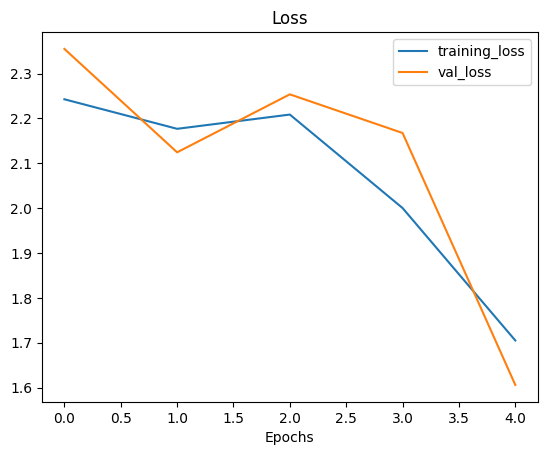

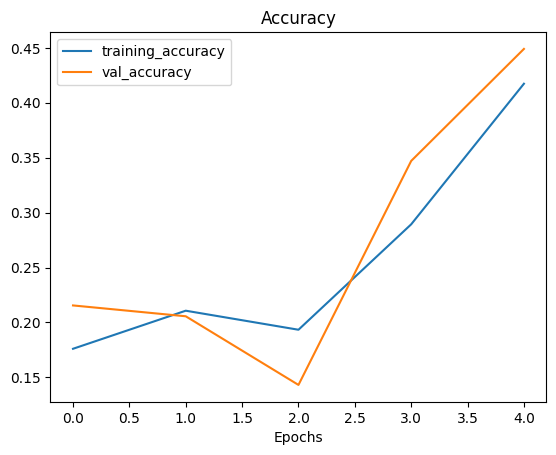

In [ ]:
# plot the model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights
Loading in checkpointed weights returns a model to a specific checkpoint.

In [ ]:
#Load in saved model weights and evaluate the model
model_2.load_weights(checkpoint_path)

In [ ]:
checkpoint_path

'10_percent_model_checkpoint_weights/checkpoint.ckpt'

In [ ]:
#Evaluate the model_2 with loaded weights
loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 112s 1s/step - loss: 1.6161 - accuracy: 0.4436


In [ ]:
#If the results from our previously evaluate model_2 match the loaded weights,everything has worked!
results_10_percent_data_aug==loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[1.6161351203918457, 0.44359999895095825]

In [ ]:
loaded_weights_model_results

[1.6161352396011353, 0.44359999895095825]

In [ ]:
#Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
#Check the difference between two results
print(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))
print(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

[1.61613512 0.4436    ] [1.61613524 0.4436    ]
[1.61613512 0.4436    ] [1.61613524 0.4436    ]


### Model 3: Fine Tunning the Model on the 10% of the data

> 🔑**Notes**: Fine-tunning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
#Layers in loaded model
model_2.layers

In [ ]:
#Are these layers trainable?
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7be596f9af20> True
<keras.src.engine.sequential.Sequential object at 0x7be596f9a470> True
<keras.src.engine.functional.Functional object at 0x7be596d8fbe0> True
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7be596f99f90> True
<keras.src.layers.core.dense.Dense object at 0x7be596d8de70> True


In [ ]:
#What are the layers in our base_model(EfficientNetB0)?
for i, layer in enumerate(model_2.layers):
  print(i,layer,layer.trainable)

0 <keras.src.engine.input_layer.InputLayer object at 0x7be596f9af20> True
1 <keras.src.engine.sequential.Sequential object at 0x7be596f9a470> True
2 <keras.src.engine.functional.Functional object at 0x7be596d8fbe0> True
3 <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7be596f99f90> True
4 <keras.src.layers.core.dense.Dense object at 0x7be596d8de70> True


In [ ]:
#How many trainable variables are in our base model?
print(len(model_2.trainable_variables))

243


In [ ]:
# TO begin fine-tunning,lets start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable=True

#Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable=False

#Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001), #when fine tunning you typically want lower the learning rate by 10x
                metrics=['accuracy'])

> 🔑**Notes** When using fine tunning its best practice to lower your learning rate by some amount.How much?this is a hyperparameter you can tune.but atleast a good thumb rule is at least 10x(though different sources will claim other values).

A good resource for information on the is the ULMFIT paper:[Universal Langauge Model fine tuning for Text Classification](https://arxiv.org/abs/1801.06146)

In [ ]:
for layer in base_model.layers[:-10]:
  print(layer.name)

input_4
rescaling_5
normalization_3
stem_conv
stem_bn
stem_activation
block1a_project_conv
block1a_project_bn
block1a_project_activation
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_project_conv
block3a_project_bn
block3b_expand_conv
block3b_expand_bn
block3b_expand_activation
block3b_project_conv
block3b_project_bn
block3b_drop
block3b_add
block4a_expand_conv
block4a_expand_bn
block4a_expand_activation
block4a_dwconv2
block4a_bn
block4a_activation
block4a_se_squeeze
block4a_se_reshape
block4a_se_reduce
block4a_se_expand
block4a_se_excite
block4a_project_conv
block4a_project_bn
block4b_expand_conv
block4b_expand_bn
block4b_expand_activation
block4b_dwconv2
block4b_bn
block4b_activation
block4b_se_squeeze
block4b_se_reshape
block4b

In [ ]:
#Check which layers are tunable(trainable)
for layer_number,layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_4 False
1 rescaling_5 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
#Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
model_2.trainable

True

In [ ]:
initial_epochs=5

In [ ]:
#Fine tun for another 5 epochs
fine_tune_epochs=initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug=model_2.fit(train_data_10_percent,
                                             epochs=fine_tune_epochs,
                                             validation_data=test_data,
                                             validation_steps=int(0.25*len(test_data)),
                                             initial_epoch=history_10_percent_data_aug.epoch[-1], # Start training from previous last epoch
                                             callbacks=[create_tensorboard_callback(
                                                 dir_name='tensorflow_hub',
                                                 experiment_name='10_percent_fine_tunning_last_10')])

Saving TensorBoard log files to: tensorflow_hub/10_percent_fine_tunning_last_10/20240721-090357
Epoch 5/10
24/24 [==============================] - 85s 3s/step - loss: 1.2785 - accuracy: 0.5733 - val_loss: 1.3017 - val_accuracy: 0.5477
Epoch 6/10
24/24 [==============================] - 76s 3s/step - loss: 1.1015 - accuracy: 0.6307 - val_loss: 1.2603 - val_accuracy: 0.5888
Epoch 7/10
24/24 [==============================] - 83s 4s/step - loss: 1.0158 - accuracy: 0.6627 - val_loss: 1.3569 - val_accuracy: 0.5477
Epoch 8/10
24/24 [==============================] - 85s 4s/step - loss: 1.0183 - accuracy: 0.6520 - val_loss: 1.1521 - val_accuracy: 0.6217
Epoch 9/10
24/24 [==============================] - 71s 3s/step - loss: 0.9487 - accuracy: 0.6787 - val_loss: 1.1826 - val_accuracy: 0.6234
Epoch 10/10
24/24 [==============================] - 85s 4s/step - loss: 0.8782 - accuracy: 0.7013 - val_loss: 1.2567 - val_accuracy: 0.6184


In [ ]:
# Evaluate the fine-tune model (model_3 which is actually model_2 fine-tune for another 5 epochs)
results_fine_tune_10_percent=model_2.evaluate(test_data)

79/79 [==============================] - 111s 1s/step - loss: 1.3124 - accuracy: 0.6016


In [ ]:
results_10_percent_data_aug

[1.6161351203918457, 0.44359999895095825]

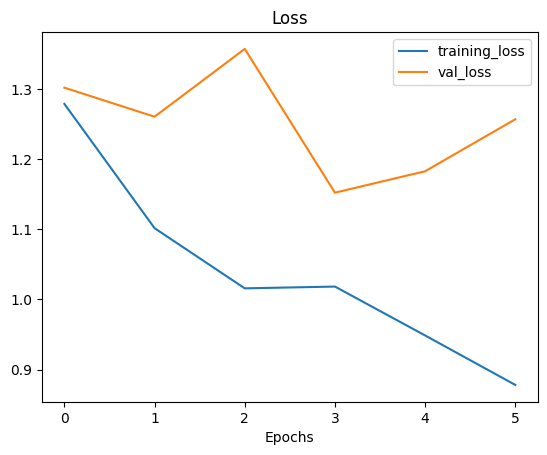

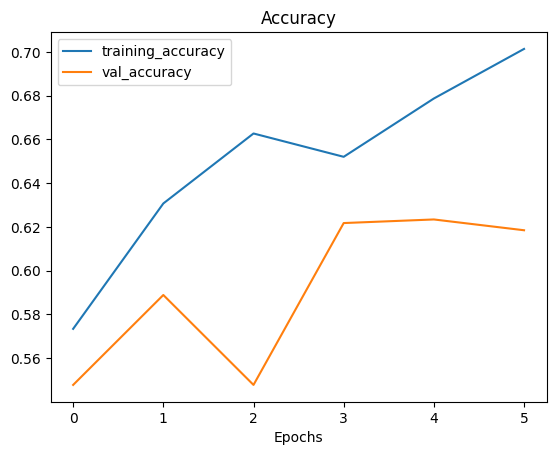

In [ ]:
# Check out the loss curves of our fine tune model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once,however,we want something to compare one series of running `fit()` with another (e.g. before and after the fine-tune).

In [ ]:
#Lets create a function to compare training histories
def compare_historys(original_history,new_history,initial_epochs=5):
  """
  Compare 2 tensorflow History of a model before and after fine-tunning
  """
  #Get orginal history measurements
  acc=original_history.history['accuracy']
  loss=original_history.history['loss']

  val_acc=original_history.history['val_accuracy']
  val_loss=original_history.history['val_loss']

  #Combine original history with new history metrics
  total_acc=acc+new_history.history['accuracy']
  total_loss=loss+new_history.history['loss']

  total_val_acc=val_acc+new_history.history['val_accuracy']
  total_val_loss=val_loss+new_history.history['val_loss']

  #Make aplot
  plt.figure(figsize=(10,10))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label='Training Accuracy')
  plt.plot(total_val_acc,label='Validation Accuracy')
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tunning')
  plt.legend(loc='upper right')
  plt.title("Accuracy of Fine-tune Model")

  plt.subplot(2,1,2)
  plt.plot(total_loss,label='Training Loss')
  plt.plot(total_val_loss,label='Validation Loss')
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tunning')
  plt.legend(loc='upper right')
  plt.title("Loss of Fine-tune Model")

  plt.show()

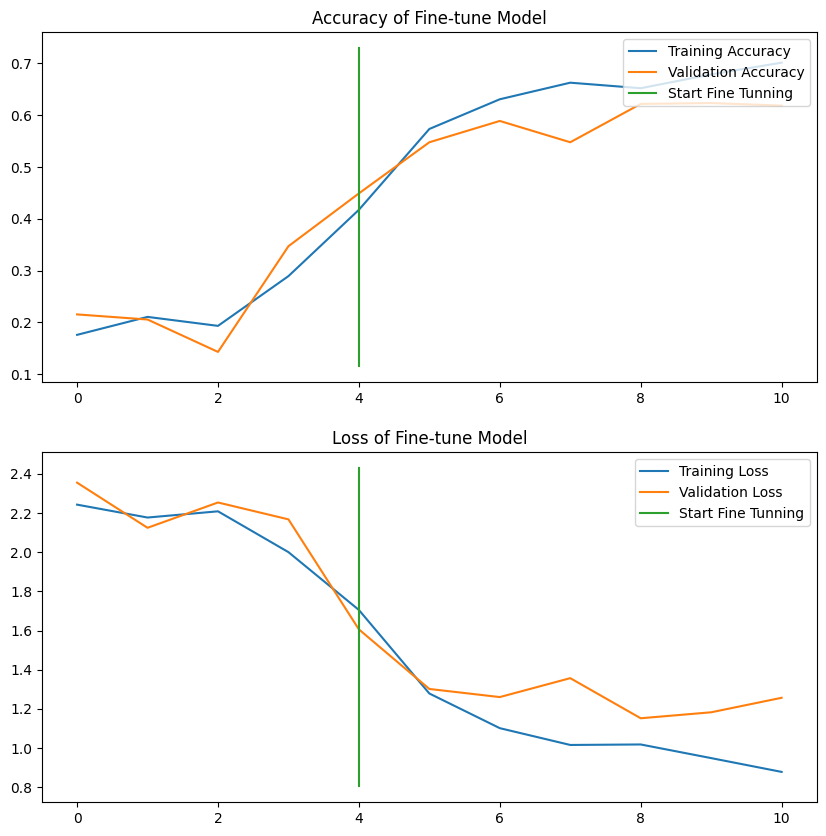

In [ ]:
compare_historys(history_10_percent_data_aug,
                history_fine_10_percent_data_aug,
                initial_epochs=5)

In [ ]:
#Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2024-07-21 09:16:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.207, 108.177.97.207, 108.177.125.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  13.2MB/s    in 36s     

2024-07-21 09:17:29 (13.7 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
unzip_data("10_food_classes_all_data.zip")

In [ ]:
#Setup training and test dir
train_dir_all_images='10_food_classes_all_data/train/'
test_dir_all_images='10_food_classes_all_data/test/'

In [ ]:
#Loading images into the directory iterators
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
train_data_100_percent=image_dataset_from_directory(directory=train_dir_all_images,
                                                    label_mode='categorical',
                                                    image_size=(224,224),
                                                    batch_size=32)

test_data=image_dataset_from_directory(directory=test_dir_all_images,
                                       label_mode='categorical',
                                       image_size=(224,224),
                                       batch_size=32)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
#How many images are we working with now?
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [ ]:
len(train_data_100_percent),len(test_data)

(235, 79)

In [ ]:
235*32,79*32

(7520, 2528)

The test dataset we've loaded in is the same as what we've been using for previous experiments(all experiments have used the same test dataset).

Let's verify this....

In [ ]:
#Evaluate model_2(this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 112s 1s/step - loss: 1.3124 - accuracy: 0.6016


[1.3124006986618042, 0.6015999913215637]

In [ ]:
results_fine_tune_10_percent

[1.312400460243225, 0.6015999913215637]

To train a fine-tunning model(model_4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
#Load weights from checkpoint ,that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
# the same stage the 10percent data model was fine-tune from
model_2.load_weights(checkpoint_path)

ValueError: Received incompatible tensor with shape (3, 3, 3, 32) when attempting to restore variable with shape (1, 1, 1152, 48) and name Adam/m/block6h_se_reduce/kernel:0.

In [ ]:
#Lets evaluate the model_2 now
model_2.evaluate(test_data)

In [ ]:
#Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckPoint` callbacks.

2. Fine-tune the same model on the same 10% of the data for a further 5 epochs with the top layers of the base model unfrozen(model_3).

3. Save the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4).


In [ ]:
#Check which layers are tunable in this whole model
for layer_number,layer in enumerate(model_2.layers):
  print(layer_number,layer.name,layer.trainable)

In [ ]:
# Lets drill into our base_model (efficientnetv2B0) and see what layers are trainable
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name,layer.trainable)

In [ ]:
#Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.00001),
                metrics=['accuracy'])

In [ ]:
#Continue to train and fine-tune the
fine_tune_epochs=initial_epochs + 5

history_fine_100_percent=model_2.fit(train_data_100_percent,
                                     epochs=fine_tune_epochs,
                                     validation_data=test_data,
                                     validation_steps=int(0.25*len(test_data)),
                                     initial_epochs=history_10_percent_data_aug.epoch-1,
                                     callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                            experiment_name='full_10_classes_fine_tune_last_10')]
                                     )

In [ ]:
#Lets evaluate on all the test data
results_fine_tune_full_data=model_2.evaluate(test_data)
results_fine_tune_full_data

In [ ]:
#How did fine-tunning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on tensorboard

> 🔑**Notes:**Anything you upload to Tensorboard.dev is going to be public.so if you have private data, do not upload.

In [ ]:
#View tensorboard logs of transfer learning modelling experiments (should be ~4 models)
#Upload Tensorboard dev records
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/tensorflow_hub/